# Facies Classification Solution By Team_BGC

Cheolkyun Jeong and Ping Zhang From Team_BGC

## Import Header

In [1]:
##### import basic function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
##### import stuff from scikit learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score,LeavePGroupsOut, LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, recall_score, precision_score

## 1. Data Prepocessing

1) Filtered data preparation

After the initial data validation, we figure out the NM_M input is a key differentiator to group non-marine stones (sandstone, c_siltstone, and f_siltstone) and marine stones (marine_silt_shale, mudstone, wakestone, dolomite, packstone, and bafflestone) in the current field. Our team decides to use this classifier aggressively and prepare a filtered dataset which cleans up the outliers.

In [2]:
# Input file paths
facies_vector_path = 'facies_vectors.csv'
train_path = 'training_data.csv'
test_path = 'validation_data_nofacies.csv'
# Read training data to dataframe
training_data = pd.read_csv(train_path)

In [3]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

# Fitering out some outliers
j = []
for i in range(len(training_data)):
    if ((training_data['NM_M'].values[i]==2)and ((training_data['Facies'].values[i]==1)or(training_data['Facies'].values[i]==2)or(training_data['Facies'].values[i]==3))):
        j.append(i)
    elif((training_data['NM_M'].values[i]==1)and((training_data['Facies'].values[i]!=1)and(training_data['Facies'].values[i]!=2)and(training_data['Facies'].values[i]!=3))):
        j.append(i)

training_data_filtered = training_data.drop(training_data.index[j])

print(np.shape(training_data_filtered))


(3179, 12)


## 2. Feature Selection

Log Plot of Facies

### Filtered Data

SS      259
CSiS    732
FSiS    599
SiSh    179
MS      206
WS      460
D        97
PS      486
BS      161
Name: Facies, dtype: int64

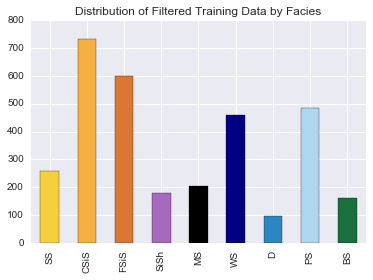

In [4]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts_filtered = training_data_filtered['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts_filtered.index = facies_labels

facies_counts_filtered.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Filtered Training Data by Facies')
#facies_counts_filtered
training_data_filtered.columns

facies_counts_filtered

### Filtered facies

In [5]:
correct_facies_labels_filtered = training_data_filtered['Facies'].values
feature_vectors_filtered = training_data_filtered.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors_filtered.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000
mean,65.975960,0.643302,3.620791,13.396139,3.733593,1.499843,0.523636
std,30.781949,0.242851,5.161355,7.670558,0.897148,0.500079,0.283774
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.724500,0.491000,1.200000,8.300000,3.101000,1.000000,0.281500
50%,65.671000,0.624000,3.500000,12.065000,3.586000,1.000000,0.529000
75%,79.612500,0.816500,6.471500,16.328000,4.300000,2.000000,0.767000
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [6]:
from sklearn import preprocessing
scaler_filtered = preprocessing.StandardScaler().fit(feature_vectors_filtered)
scaled_features_filtered = scaler_filtered.transform(feature_vectors_filtered)

In [108]:
from sklearn.cross_validation import train_test_split

X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
        scaled_features_filtered, correct_facies_labels_filtered, test_size=0.3, random_state=16)

In [98]:
X_train_full, X_test_zero, y_train_full, y_test_full = train_test_split(
        scaled_features_filtered, correct_facies_labels_filtered, test_size=0.0, random_state=42)

## 3. Prediction Model

Accuracy

In [80]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [81]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

SVM

In [82]:
from sklearn.model_selection import KFold, cross_val_score,LeavePGroupsOut, LeaveOneGroupOut, cross_val_predict
from classification_utilities import display_cm, display_adj_cm

In [83]:
from sklearn import svm
clf_filtered = svm.LinearSVC(random_state=23) 

In [84]:
clf_filtered.fit(X_train_filtered, y_train_filtered)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=23, tol=0.0001,
     verbose=0)

In [85]:
predicted_labels_filtered = clf_filtered.predict(X_test_filtered)

SVM for filtered data model

In [86]:
conf_filtered = confusion_matrix(y_test_filtered, predicted_labels_filtered)
display_cm(conf_filtered, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    33    19                                              52
     CSiS    29   128    28                                       185
     FSiS     4    61    87                                       152
     SiSh                      20     1    14     3     3          41
       MS                       4     1    23     2    15          45
       WS                       9          95     4    26     2   136
        D                       3           1     8    10          22
       PS                       2     1    31     1    80     4   119
       BS                       3           2          14    24    43

Precision  0.50  0.62  0.76  0.49  0.33  0.57  0.44  0.54  0.80  0.60
   Recall  0.63  0.69  0.57  0.49  0.02  0.70  0.36  0.67  0.56  0.60
       F1  0.56  0.65  0.65  0.49  0.04  0.63  0.40  0.60  0.66  0.58


In [87]:
print('Facies classification filtered accuracy = %f' % accuracy(conf_filtered))
print('Adjacent facies classification filtered accuracy = %f' % accuracy_adjacent(conf_filtered, adjacent_facies))

Facies classification filtered accuracy = 0.598742
Adjacent facies classification filtered accuracy = 0.920755


Model Solution for select parameter

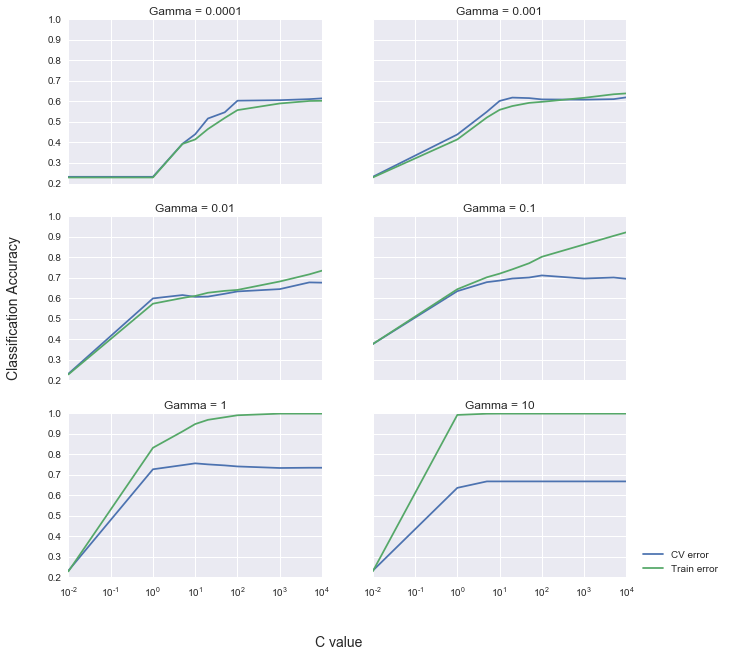

In [88]:
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2)
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf_filtered = svm.SVC(C=c_value, gamma=gamma_value)
            clf_filtered.fit(X_train_filtered,y_train_filtered)
            
            train_conf_filtered = confusion_matrix(y_train_filtered, clf_filtered.predict(X_train_filtered))
            cv_conf_filtered = confusion_matrix(y_test_filtered, clf_filtered.predict(X_test_filtered))
        
            cv_errors[index] = accuracy(cv_conf_filtered)
            train_errors[index] = accuracy(train_conf_filtered)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

SVM using optimized parameter for filtered data model

In [89]:
#clf_filtered = svm.LinearSVC(class_weight='balanced', tol=1e-03, random_state=42)        
clf_filtered = svm.SVC(C=10, gamma=1)
clf_filtered.fit(X_train_filtered, y_train_filtered)

cv_conf_filtered = confusion_matrix(y_test_filtered, clf_filtered.predict(X_test_filtered))

print('Optimized facies classification filtered accuracy = %.2f' % accuracy(cv_conf_filtered))
print('Optimized adjacent facies classification filtered accuracy = %.2f' % accuracy_adjacent(cv_conf_filtered, adjacent_facies))

Optimized facies classification filtered accuracy = 0.76
Optimized adjacent facies classification filtered accuracy = 0.96


In [90]:
display_cm(cv_conf_filtered, facies_labels, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    39    12     1                                        52
     CSiS    15   150    20                                       185
     FSiS     7    43   102                                       152
     SiSh                      39                       2          41
       MS                       5    31     5     1     3          45
       WS                       7    10    97     2    19     1   136
        D                       1     1          16     3     1    22
       PS                       1     5    15     3    93     2   119
       BS                                   1     3     5    34    43

Precision  0.64  0.73  0.83  0.74  0.66  0.82  0.64  0.74  0.89  0.76
   Recall  0.75  0.81  0.67  0.95  0.69  0.71  0.73  0.78  0.79  0.76
       F1  0.69  0.77  0.74  0.83  0.67  0.76  0.68  0.76  0.84  0.76


## 4. Result Analysis

In [115]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

In [110]:
X_unknown = scaler_filtered.transform(well_features)

# Using all data and optimize parameter to train the data
clf_filtered = svm.SVC(C=10, gamma=1)
clf_filtered.fit(X_train_full, y_train_full)
#clf_filtered.fit(X_train_filtered, y_train_filtered)
y_unknown = clf_filtered.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data
well_data.to_csv('predict_result.csv')

## 5. Using Tensorflow

Filtered Data Model

In [112]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf

# Specify that all features have real-value data
feature_columns_filtered = [tf.contrib.layers.real_valued_column("", dimension=7)]

# Build 3 layer DNN with 7, 17, 10 units respectively.
classifier_filtered = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns_filtered,
                                            hidden_units=[7, 17, 10],
                                            n_classes=10)

# Fit model.
classifier_filtered.fit(x=X_train_filtered,
               y=y_train_filtered,
               steps=5000)


y_predict_filtered = []
predictions = classifier_filtered.predict(x=X_test_filtered)

for i, p in enumerate(predictions):
    y_predict_filtered.append(p)
    #print("Index %s: Prediction - %s, Real - %s" % (i + 1, p, y_test_filtered[i]))

# Evaluate accuracy.
accuracy_score_filtered = classifier_filtered.evaluate(x=X_test_filtered, y=y_test_filtered)["accuracy"]
print('Accuracy: {0:f}'.format(accuracy_score_filtered))

cv_conf_dnn = confusion_matrix(y_test_filtered, y_predict_filtered)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf_dnn))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf_dnn, adjacent_facies))
display_cm(cv_conf_dnn, facies_labels,display_metrics=True, hide_zeros=True)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'tf_random_seed': None, '_num_ps_replicas': 0, 'keep_checkpoint_max': 5, 'keep_checkpoint_every_n_hours': 10000, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'save_checkpoints_secs': 600, '_task_id': 0, '_is_chief': True, '_task_type': None, 'save_summary_steps': 100, '_evaluation_master': '', '_master': '', '_environment': 'local', 'save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000011475A90>}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and b

Result from DNN

In [117]:
#classifier_filtered.fit(x=X_train_full,
#               y=y_train_full,
#               steps=10000)
#y_unknown_DNN = classifier_filtered.predict(X_unknown)
#well_data['Facies'] = y_unknown
#well_data
#well_data.to_csv('predict_result_dnn.csv')

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Summary name dnn/hiddenlayer_0:fraction_of_zero_values is illegal; using